## 0. Install Necesaary Libary and Import Packages

In [1]:
import nltk
from nltk.corpus import brown
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from itertools import chain
from collections import Counter

In [2]:
# Download NLTK data
nltk.download('brown')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package brown to /home/sunil/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/sunil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sunil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Preprocessing and Selection

### 1(a). Preprocessing

In [3]:
corpus = brown.sents()
corpus

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ...]

In [4]:
def count_sentences_words(text):
    # Count number of sentences
    num_sentences = len(text)
    print("Number of sentences: ", num_sentences)
    # Count number of words
    num_words = sum(len(sentence) for sentence in text)
    print("Number of words: ", num_words)

In [5]:
count_sentences_words(corpus)

Number of sentences:  57340
Number of words:  1161192


In [6]:
%%time
def preprocess_corpus(corpus):
    stop_words = set(stopwords.words('english'))
    preprocessed_corpus = []
    for sentence in corpus:
        preprocessed_sentence = []
        for token in sentence:
            token = token.lower()
            if token not in stop_words:
                if token.isalpha():
                    preprocessed_sentence.append(token)
        preprocessed_corpus.append(preprocessed_sentence)
    
    # Remove rare words
    word_freq = Counter(chain(*preprocessed_corpus))
    rare_words = set(word for word in word_freq.elements() if word_freq[word] < 5)
    preprocessed_corpus = [[word for word in sentence if word not in rare_words] for sentence in preprocessed_corpus]
    
    return preprocessed_corpus

preprocessed_brown_corpus = preprocess_corpus(brown.sents())
print("Preprocessed Brown Corpus:\n", preprocessed_brown_corpus[:10])

Preprocessed Brown Corpus:
 [['fulton', 'county', 'grand', 'jury', 'said', 'friday', 'investigation', 'recent', 'primary', 'election', 'produced', 'evidence', 'irregularities', 'took', 'place'], ['jury', 'said', 'city', 'executive', 'committee', 'charge', 'election', 'deserves', 'praise', 'thanks', 'city', 'atlanta', 'manner', 'election', 'conducted'], ['term', 'jury', 'charged', 'fulton', 'superior', 'court', 'judge', 'investigate', 'reports', 'possible', 'irregularities', 'primary', 'allen'], ['relative', 'handful', 'reports', 'received', 'jury', 'said', 'considering', 'widespread', 'interest', 'election', 'number', 'voters', 'size', 'city'], ['jury', 'said', 'find', 'many', 'registration', 'election', 'laws', 'inadequate', 'often', 'ambiguous'], ['recommended', 'fulton', 'legislators', 'act', 'laws', 'studied', 'revised', 'end', 'improving'], ['grand', 'jury', 'commented', 'number', 'topics', 'among', 'atlanta', 'fulton', 'county', 'purchasing', 'departments', 'said', 'well', 'opera

In [7]:
count_sentences_words(preprocessed_brown_corpus)

Number of sentences:  57340
Number of words:  463133


### 1.(b) Selection

In [8]:
sentences = preprocessed_brown_corpus[:57340]

In [9]:
count_sentences_words(sentences)

Number of sentences:  57340
Number of words:  463133


## 2. Implementation of Word2Vec

In [10]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

/home/sunil/sunil2_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
%%time

# define SkipGram class
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, center_word):
        embedded = self.embeddings(center_word)
        out = self.linear(embedded)
        return out

def get_input_tensor(sentence, word_to_ix):
    tensor = torch.zeros(len(sentence), dtype=torch.long)
    for i, word in enumerate(sentence):
        tensor[i] = word_to_ix[word]
    return tensor

# set hyperparameters
EMBEDDING_DIM = 40
LR = 0.01
EPOCHS = 20

# create vocabulary
vocab = []
for sentence in sentences:
    vocab.extend(sentence)
vocab = list(set(vocab))
vocab_size = len(vocab)

# create word-to-index and index-to-word mapping
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

# create training data
data = []
for sentence in sentences:
    for i, center_word in enumerate(sentence):
        for j in range(max(0, i-2), min(len(sentence), i+3)):
            if i != j:
                data.append((center_word, sentence[j]))

# initialize model
model = SkipGram(vocab_size, EMBEDDING_DIM)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# train model
losses = []
for epoch in range(EPOCHS):
    running_loss = 0.0
    for center_word, context_word in data:
        # convert words to tensors
        center_word_tensor = torch.tensor([word_to_ix[center_word]], dtype=torch.long)
        context_word_tensor = torch.tensor([word_to_ix[context_word]], dtype=torch.long)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(center_word_tensor)
        loss = criterion(outputs, context_word_tensor)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    epoch_loss = running_loss/len(data)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}")

Epoch 1/20, Loss: 12.3998
Epoch 2/20, Loss: 12.3151


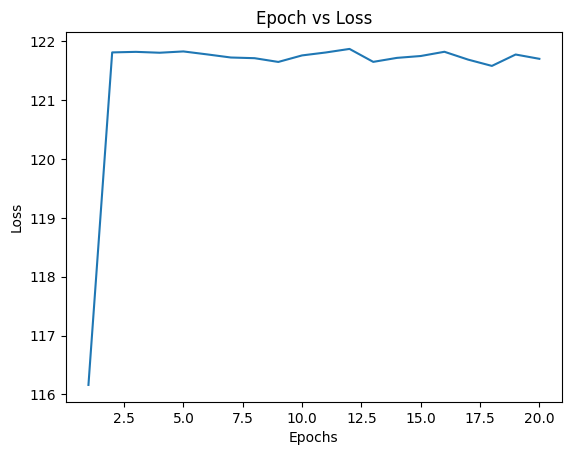

In [13]:
# plot epoch vs loss graph
plt.plot(range(1, EPOCHS+1), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.show()

In [14]:
# get word embeddings
word_embeddings = model.embeddings.weight.data.numpy()
# print word embeddings
for i, word in enumerate(vocab):
    print(f"{word}: {word_embeddings[i]}")

peers: [ 2.7223284e+00  1.5608115e+00  6.5710098e-01  1.2806906e+00
  3.2232916e+00 -2.0495083e+00  3.7280533e+00  1.7454603e+00
  3.7767999e+00 -3.7486517e+00 -4.5332730e-01  1.0032903e+00
  2.5967107e+00 -7.6081473e-01 -2.4467146e-01  2.0339589e+00
  2.5402548e+00  3.6060498e+00  7.0759177e-02 -8.5113071e-02
  4.6525831e+00  1.0107874e+00  3.1934946e+00 -3.8488495e-01
  1.0945238e+00  4.3114233e-03  1.3090659e+00 -1.3861052e+00
  3.0800757e+00  1.0316074e+00 -6.5053329e+00  3.3953397e+00
 -4.4561858e+00 -3.9211023e+00  2.8283360e+00 -5.4174319e-02
 -1.3310637e+00 -3.1699660e+00  4.7784142e+00 -3.0977443e-02]
affiliated: [ 1.920838   -1.813434   -2.9827077   0.08283437  1.9444318   2.549044
 -2.0768652   6.5311036  -5.2301316  -0.5028093  -3.8819711  -2.8133166
  1.9872744  -0.6987068   2.8749208   6.714176    0.5553804  -0.20882595
 -0.71436423  2.7108088  -0.9156351  -1.5672619   2.6667447  -2.4750805
 -1.8103822   2.0180526  -1.0680412  -0.7136452  -2.647739   -3.3122857
  1.796916

deliberations: [-1.5961121   2.1939538   0.820257    0.35847348  1.1328316   2.489487
  0.20502698 -3.982371   -5.1284595  -4.7114162   4.612465   -1.781269
  1.7014164   4.83505    -1.4752237  -6.5082555   1.9549711   5.1494718
  0.6788538   1.1680071   6.314258   -1.8143303   3.3977828   3.2633965
 -0.65215915  1.2829976   4.193562    1.601744    0.45938668  1.5303787
 -1.1193788  -0.34847495  0.57065237  0.77898854 -5.7803144  -0.7186992
  0.9540939   1.2795137  -6.1892815  -1.6150656 ]
tying: [ 3.3940833  -5.870134   -0.21576566 -2.4427626  -3.0558202  -2.0083477
  0.90322477  1.640138   -1.1181606   2.1102915   1.0097791  -1.6154684
 -1.9499825  -0.97901964 -0.02662586 -0.19310302 -3.7673874  -1.7922475
  1.5173482   0.82306665 -4.2184205   4.239446   -0.06250703  1.0052459
 -2.6409304   0.4137665  -0.09826126  1.7498875   0.48764354  1.8248333
 -2.9212432   0.88914835 -0.5483348  -3.5713356  -0.6287361   4.7179513
 -1.5018432   3.0713177   6.9770737  -4.964714  ]
pilot: [ 2.48046

allows: [-2.892345    5.199768   -0.29446077 -3.8553262  -2.4708536  -5.419248
  1.8618056  -1.7417188  -4.763202   -1.9918723  -0.75496083  0.69387496
 -2.8526647   0.7556192  -1.3751996  -2.5516086   3.564542    1.8198311
 -0.35849094  1.9348769  -1.2987193  -1.4112912  -3.0175564  -0.3481441
  4.5492287  -3.2951517  -2.6513853  -2.7005699   3.302879   -0.7818321
 -1.0944052   0.32396534  1.1052395  -1.0525978   6.031067    0.8343139
  0.7934403  -0.29232192 -0.46123517 -4.53791   ]
found: [ 4.628171   -1.2282207  -2.9774327  -0.82661074 -2.3393238   2.452926
  3.9425492  -2.7973735  -2.0079079   3.423422    1.6649666   2.6120555
  4.759793   -3.183065    2.0076468   0.10959548  2.6697993  -0.68181133
  5.4499187   0.8711684  -1.269922    1.4880092  -3.3314521  -2.11917
  1.5911001  -1.8445266  -2.5389109  -3.4063962   2.5596364   7.1621456
  0.772615   -0.32361245  1.4614505   4.0476847   1.5742     -1.0767031
  4.322121    2.1741347   3.2666929   1.203082  ]
berman: [ 0.12461004 -1

dc: [ 1.4822732   1.468096    0.64663374 -0.2589597  -1.0300685   0.60542625
 -0.57169545  1.3582546   1.2163241   0.9131286  -0.17428464 -3.2608109
 -0.7468433  -1.1605164  -0.9018968   3.0391762   1.7030193   0.19111584
 -0.8154203   2.0874999  -0.1281477   1.301157   -1.2471272  -2.440225
  0.6190673  -1.3503042   1.5217786  -0.46424645  0.62932897  1.6345577
 -0.37966332 -0.5407911  -1.725521   -1.4789383  -1.1593415  -0.18780428
 -1.0684735  -0.76215756 -0.15320721 -1.5584881 ]
lester: [ 1.4576606   1.5878738  -2.4335725   2.353803   -0.587415   -2.0750928
  0.5393198  -1.4896495   2.1059914  -1.259624    1.0659828  -1.9346753
 -0.6044444   1.0034646   1.8596787  -0.41757593  1.104822    1.9376951
  0.5546836  -0.26475808  1.4843646  -3.594197   -0.99611336  0.5107141
  1.1496606   2.75907     0.658695    3.624569   -0.6136369   0.42438075
  0.82833856  0.0423534  -0.01124767  0.11026385  0.42108592  3.7640588
 -0.84048265 -1.6031512   1.6670309  -2.040614  ]
contents: [ 0.8264783

serial: [-0.0165037  -1.1778259   2.217488    1.2666675  -4.95589    -2.167283
 -3.2359734  -0.43188465 -1.3740612  -0.97699076 -1.7221508  -1.3082832
  0.33672613  2.3538477   5.7960625   2.6742454   2.359798    3.5206735
  1.5474385   2.1824105  -0.76189107 -1.835155    2.0384579  -3.3965516
 -0.309884   -4.0947814  -1.0087297   0.7430971   0.8565124   3.1666925
  0.64273053 -0.15002799 -0.8598849   0.38442802  0.47470495  1.8735262
 -3.9510045   1.1494755   7.0777907   0.38554665]
trade: [ 1.8115814e+00 -9.9575078e-01 -5.5982494e+00 -3.7153378e+00
  4.3904195e+00  5.1350832e+00 -5.4994597e+00 -2.1588128e+00
  4.8955688e+00 -3.1000102e-01 -3.7183065e+00 -1.6642574e+00
  1.8175924e+00 -3.3702037e+00 -3.9225702e+00  7.3864138e-01
  1.2019701e+00 -3.1990838e+00 -3.6297541e+00  1.1352125e+00
  3.8749824e+00  2.9777024e+00 -3.5417626e+00 -7.6271051e-01
 -1.9802703e+00  6.4797109e-01 -5.4133797e+00 -3.6334996e+00
  4.8507666e-03  4.9561830e+00 -8.5945827e-01 -2.2710514e+00
 -6.6480585e-03 

giles: [-0.45712298 -2.0695724  -0.00665957  0.51296276 -4.4385185   3.8180923
 -0.47475505  0.3796108  -0.3309263   2.0042934   0.8150451  -1.4614371
 -0.20804189  4.187528   -0.8760857  -0.06722826  2.4353592   0.32081923
  4.5384965   3.3596787   2.2107484  -1.6618586  -2.552577    1.9357576
 -4.61041    -2.7767065   2.1099298   3.0416121   1.2207879  -0.7885975
  1.7441952  -0.57808405 -1.3985159  -0.41748232 -3.200992   -1.1521208
  2.0359735   2.780703    0.70470697 -4.173286  ]
court: [-1.2308636  -2.3253536   4.241582   -2.055268   -0.59158546  1.7403516
 -0.7982762  -1.3374501  -3.5613086   2.4534247  -1.963951    0.4295047
  1.1069096   0.67907685  0.95433444  2.4470115   1.2456183  -0.55921507
 -2.9698124  -6.0340643   2.3190024   1.9122957  -0.26587394  1.070237
  4.509543    0.80506176 -3.2638137   1.1004226  -0.8188288   0.78996724
  1.7616403   2.3505619  -3.695071   -2.1769652  -2.269153   -1.5944129
 -3.1874688  -1.3139579  -3.5249853   0.90707856]
club: [ 1.4437551e+0

opposition: [-2.6730297   3.370379   -3.4685857  -1.8232956  -0.74756163 -2.8189743
 -0.8451736   2.9187725   2.5927167   3.852424   -0.39207438 -0.11851887
  2.8393748  -3.276363   -1.6200033  -0.05166643  0.20710695 -3.3165865
  4.6507797   2.1509829  -0.5998532   0.869703    1.6386604  -0.12698726
  2.626879    0.7258079  -1.4425976   2.5755405  -1.1762888  -1.9218631
 -0.09069243  2.0237129   2.6110384   2.4394767   3.7083633   6.345722
 -1.7755364  -1.2170416   0.8116785  -1.6991138 ]
fulfill: [-1.5915349   0.02113341  4.241471    4.699125   -1.6724925   1.7090253
  0.11544037 -0.7887557  -0.7379198   1.2009563  -2.0063665  -0.98379284
 -3.2379053  -1.1515009  -3.9136302   3.2412236   1.7346057   0.5087623
  1.7606052   3.938771   -0.80302423 -0.60137784  2.394189   -2.0079832
 -0.6036668   3.1740618  -3.27899     2.0448735  -0.72282916  1.9932556
 -2.4880168  -1.263516    2.9938173  -0.5183292   1.1887383   5.4831986
 -2.2847002  -2.6040146   0.427446   -4.3072147 ]
budapest: [ 4

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



untouched: [-2.0870848  -2.1317043  -1.2239503  -1.1742327  -4.9253454   2.9330676
 -3.2977028  -0.93250436 -2.1720223   0.7879524  -1.9158571   1.3294281
  1.4753213   2.1149588   0.3135021  -2.699071   -6.3109283  -1.8870304
  1.1151875  -1.218229    0.43752688  1.5925107  -1.933915    6.2128015
 -0.9875671   1.7297126   3.8815475  -1.9188285   0.47048858 -0.78814703
  1.891712   -0.89261836  3.9855447   1.7504866  -5.269234   -0.9902112
 -1.0257474  -2.2189472  -2.820874   -4.2148576 ]
boarded: [-4.665717    2.9273293   0.72945327  4.414113   -2.8056023   4.4191856
 -1.4910814   0.5293835   1.1224824   3.843454    0.30401075 -0.63326716
 -0.46531656 -1.2576694  -3.3298156  -1.431106   -1.870618   -1.0064995
 -0.36506644 -1.3019807   3.3507478  -0.01165313  1.1015747  -0.48169765
 -7.3117766   0.04573783  1.2240043   0.7471685  -3.9893715  -1.2509257
 -0.26977417 -0.50771827 -0.38438004  2.5497513   4.4626637  -1.2419404
  0.27108103  0.41419718 -1.8672311  -3.9253283 ]
ground: [ 1.1

folded: [ 3.342643   -3.2864356   0.9207609  -2.4061198  -0.7682395  -3.7008376
  0.7608948   1.23972     2.503072   -1.8357487   3.2122002  -0.75378
 -0.66529524 -3.0873811  -0.09892013 -2.116842   -5.6542683  -1.19853
 -0.6068788   2.8023643  -3.8257039   0.22231048 -0.35002983  3.016772
 -2.9756854   2.8257365  -1.4151329  -0.76199335 -1.4125422  -2.826519
 -4.6705527   3.1677053   1.8654914   0.6455589  -1.8848517  -0.99482995
 -1.6296526   3.6277616   1.5898206   1.5368621 ]
offer: [ 1.7116896  -1.833573    4.9770145   2.8779857   4.4190893   2.4657109
  2.9934065   0.62578446  3.6877298   0.12677762  2.8656642   1.1521485
 -1.6176838  -1.6599039  -1.21164    -0.2160995   0.55878454  0.5078113
 -0.24923295 -0.70964193  2.5674603  -0.09206242 -5.2971525   0.35405314
  2.2208993  -2.2756503   1.3255953   0.5205472  -3.1129084   4.1946507
 -2.5743136  -0.23450594  2.6766777   2.7141087  -2.9073393   4.501743
 -2.2912407  -0.54206383  0.71769196  0.8649537 ]
highways: [-2.3849792  -0.

provide: [ 2.2402375   0.06391166  6.218387   -0.46922815 -4.110707   -2.2382874
 -5.049736    2.2035115   1.771437    2.4031584  -0.7714034   6.4545817
 -0.44916788 -2.2720892  -1.8506128   2.055272   -3.4826472  -1.4551423
  2.671098    2.2995296  -4.097096    0.2983434   2.4741042   3.252437
 -0.83183384  5.235952    1.4754949   0.9822694  -1.6677713  -4.3859963
 -2.4299285   6.1093044  -2.6303697   2.1600442  -1.4821795  -3.8699057
 -3.6262147  -3.4516623  -2.494164    0.43116164]
lease: [ 1.1084118  -1.5986536   0.00924798  0.25642535  2.2722735  -3.1841037
 -3.1742666   1.886855   -0.36152896 -2.0848768   0.12127943 -0.8474803
  1.2649822   1.6886964   2.8333788  -0.6200933   0.71980995 -0.11975193
 -4.153067    1.3988283   0.85920227  3.0964293  -0.40256068  1.9713119
  0.74835443 -0.55966747 -4.598428    1.2161684   3.0659518  -4.052243
 -1.2927793  -2.7111113  -1.6041703   3.1134655  -1.4295154   0.16902429
  1.4600035  -2.5595329   0.37064868  0.2891473 ]
memory: [-3.2386436 

tide: [ 2.1905394e+00 -5.8330524e-01  3.1469810e+00 -3.9377739e+00
  3.0143900e+00  1.6907625e+00 -3.8473901e-01  2.8134789e+00
 -3.3593228e-01 -3.0572596e+00 -1.0672022e+00  2.3372822e+00
 -1.7356305e+00  1.2788993e+00  1.2631363e-01 -6.1783141e-01
 -3.6585793e-01  3.5005901e+00 -3.2045267e+00  1.6380941e+00
 -1.6491432e+00  5.1043576e-01  1.0533568e-01 -1.9710257e-03
 -8.4297675e-01 -4.1075194e-01 -2.9770806e+00 -9.1992557e-01
  5.0659661e+00 -3.8886874e+00 -8.4272680e+00  9.6846990e-02
  1.0478396e+00  9.5643169e-01 -3.8745518e+00 -6.1410713e+00
 -3.8589323e+00  3.6270037e-01 -1.1094561e+00 -8.0860174e-01]
easily: [-1.0638998   2.6583114  -1.1916405   2.0849097   4.093685   -0.3844851
 -0.23078035  3.1500275   3.5156076   2.0889452   0.45293838  3.8718297
  0.9502377   0.46499786  0.8550887  -0.64279044 -0.505898    1.8279756
 -4.252966    5.1951766   0.7184492  -0.7739882   2.6042905   0.7073408
 -3.3230574  -0.6960381  -3.0586889  -1.4882715  -1.4905959   0.17466833
 -1.0452812   

In [15]:
# save the trained model
torch.save(model.state_dict(), 'skipgram_model.pt')

In [16]:
# create a new instance of the SkipGram class
model = SkipGram(vocab_size, EMBEDDING_DIM)

# load the saved state dictionary
model.load_state_dict(torch.load('skipgram_model.pt'))

# set the model to evaluation mode
model.eval()

SkipGram(
  (embeddings): Embedding(13232, 40)
  (linear): Linear(in_features=40, out_features=13232, bias=True)
)

## 3. Investigation

### Investigation part (a)

In [17]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_similar_words(word, model, vocab, ix_to_word, top_k=5):
    # get the index of the given word
    word_index = vocab.index(word)

    # get the embedding of the given word
    word_embedding = model.embeddings.weight.data.numpy()[word_index]

    # calculate the cosine similarities between the embedding of the given word and all the other embeddings
    similarities = cosine_similarity(word_embedding.reshape(1, -1), model.embeddings.weight.data.numpy())[0]

    # sort the similarities in descending order and get the top k most similar words
    similar_word_indices = similarities.argsort()[::-1][1:top_k+1]
    similar_words = [ix_to_word[i] for i in similar_word_indices]

    return similar_words


In [18]:
word = 'election'
similar_words = get_similar_words(word, model, vocab, ix_to_word)
print(f"The top 5 most similar words to '{word}' are: {', '.join(similar_words)}")


The top 5 most similar words to 'election' are: percussive, phone, considers, terry, answered


In [19]:
# Find the Similarity between the word
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def word_similarity(word1, word2, word_to_ix, model):
    idx1 = word_to_ix[word1]
    idx2 = word_to_ix[word2]
    emb1 = model.embeddings(torch.tensor([idx1], dtype=torch.long))
    emb2 = model.embeddings(torch.tensor([idx2], dtype=torch.long))
    sim = cosine_similarity(emb1.detach().numpy(), emb2.detach().numpy())
    return sim[0][0]


In [20]:
word1 = 'friday'
word2 = 'recent'
similarity = word_similarity(word1, word2, word_to_ix, model)
print(f"Similarity between '{word1}' and '{word2}': {similarity:.4f}")

Similarity between 'friday' and 'recent': 0.0592


In [21]:
word1 = 'governments'
word2 = 'departments'
similarity = word_similarity(word1, word2, word_to_ix, model)
print(f"Similarity between '{word1}' and '{word2}': {similarity:.4f}")

Similarity between 'governments' and 'departments': -0.0713


In [22]:
# Find Top Similar words
from sklearn.metrics.pairwise import cosine_similarity
def get_top_similar_words(word, word_to_ix, model, n=5):
    idx = word_to_ix[word]
    emb = model.embeddings(torch.tensor([idx], dtype=torch.long))
    word_embeddings = model.embeddings.weight.data.numpy()
    similarities = cosine_similarity(emb.detach().numpy(), word_embeddings)
    sorted_indices = np.argsort(similarities)[0][::-1][:n]
    similar_words = [ix_to_word[i] for i in sorted_indices if i != idx]
    return similar_words

In [23]:
word = 'friday'
similar_words = get_top_similar_words(word, word_to_ix, model, n=5)
print(f"Top 5 similar words to '{word}': {similar_words}")


Top 5 similar words to 'friday': ['avoidance', 'hydrolysis', 'reservations', 'strengthened']


### Investigation part (c)

/home/sunil/sunil2_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/sunil/sunil2_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


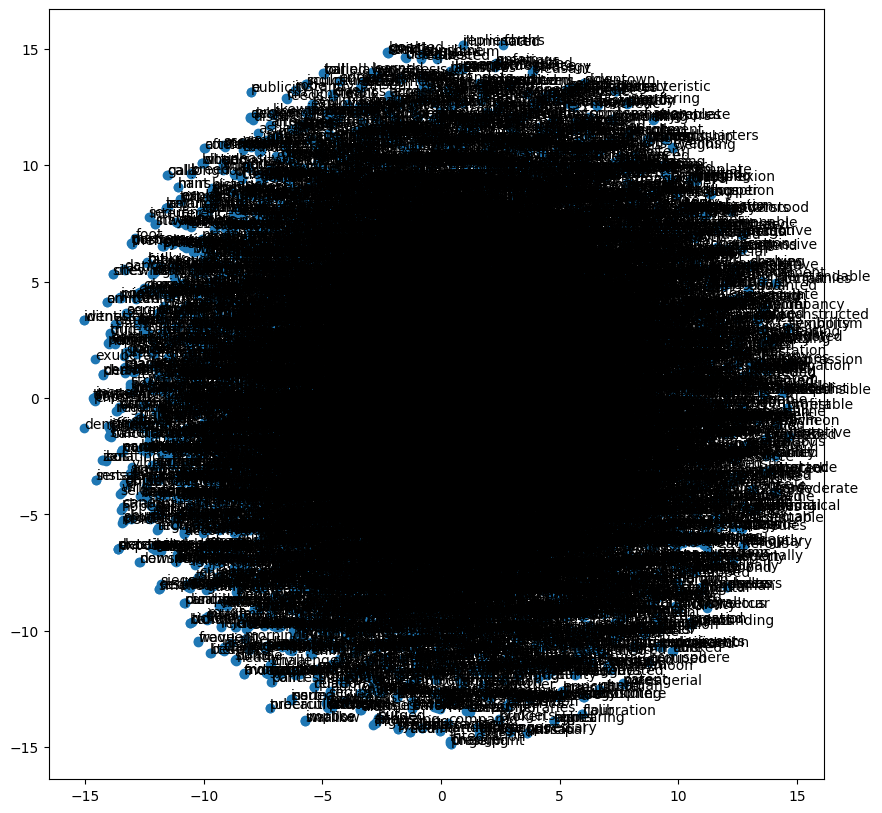

In [24]:
import matplotlib.pyplot as plt

# get 2d embeddings using t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
word_embeddings_2d = tsne.fit_transform(word_embeddings)

# plot the embeddings
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1])

# annotate the points with the words
for i, word in enumerate(vocab):
    ax.annotate(word, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]))

plt.show()


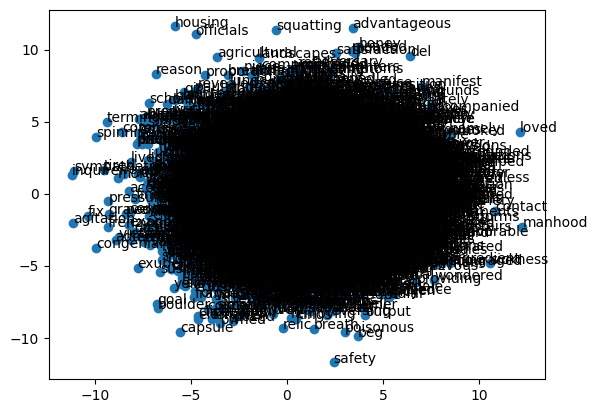

In [25]:
import numpy as np

# apply SVD to reduce the dimensionality of the embeddings to 2
U, S, Vt = np.linalg.svd(word_embeddings)
reduced_embeddings = np.dot(word_embeddings, Vt[:2].T)

# plot the reduced embeddings
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

# annotate each point with its corresponding word
for i, word in enumerate(vocab):
    ax.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.show()


### Investigation part (d)

In [26]:
import numpy as np

# define the analogy
a = "jury"
b = "topics"
c = "county"

# calculate vector differences
vec_a = word_embeddings[word_to_ix[a]]
vec_b = word_embeddings[word_to_ix[b]]
vec_c = word_embeddings[word_to_ix[c]]
diff1 = vec_a - vec_b
diff2 = vec_c - diff1

# find closest word in vocabulary
distances = np.linalg.norm(word_embeddings - diff2, axis=1)
closest_word_index = np.argmin(distances)
closest_word = ix_to_word[closest_word_index]

# print the answer
print(f"grant {a} commented number {b} among {closest_word} fulton {c}")


grant jury commented number topics among wakeful fulton county


## 4. Innovation